# Greenland Ice Surface temperatures 48000 BC to 1884 AD


### What is the significance of the current 100 year warming trend? And how much change is it, anyway?

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.image as img
from scipy import interpolate
from matplotlib import rcParams
%pylab --no-import-all notebook

def width_height(length=15,width=7.5):
    rcParams['figure.figsize'] = (length, width)

width_height(14,6)

# Just change this currency_directory variable string to your correct data folder

def load_csv(file_name,parse_dates=False):
    try:
        df = pd.read_csv(file_name,
                         header=0,
                         index_col=0,
                         parse_dates=parse_dates,
                         )
    except OSError:
        print('Could not find {f}'.format(f=file_name))
    return df

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


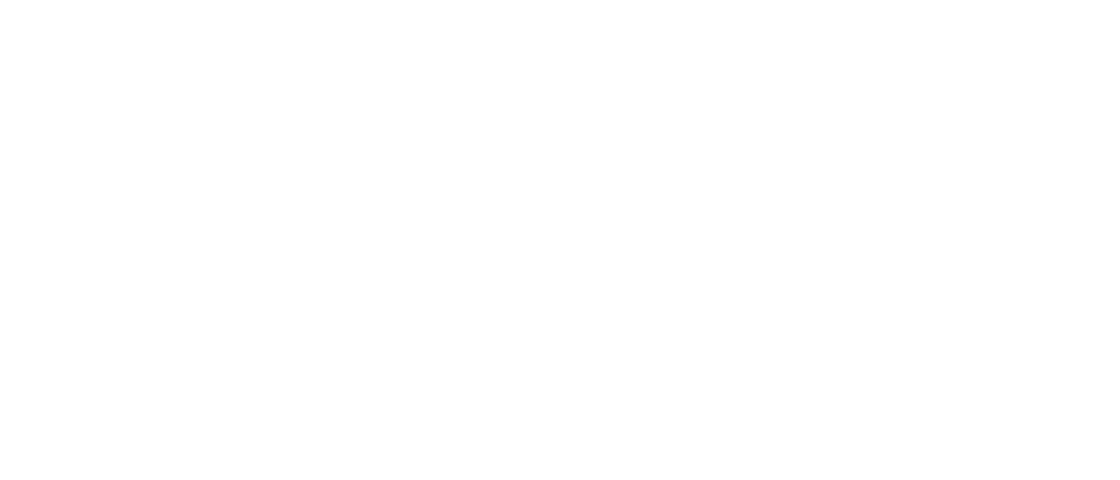

In [2]:
# Loading data and fixing indexes
gisp2 = load_csv(r'gisp2_data.csv')
gisp2.index = gisp2.index *-1000 + 1950
gisp2.sort_index(ascending=True,inplace=True)

# Initial plot
disappear = plt.plot(gisp2)
plt.title('Greenland ice core temperatures over time, ~48000BC to 1884, GISP2 dataset')
plt.ylabel('Celsius')
plt.xlabel('Year (negative is BC)')

<IPython.core.display.Javascript object>


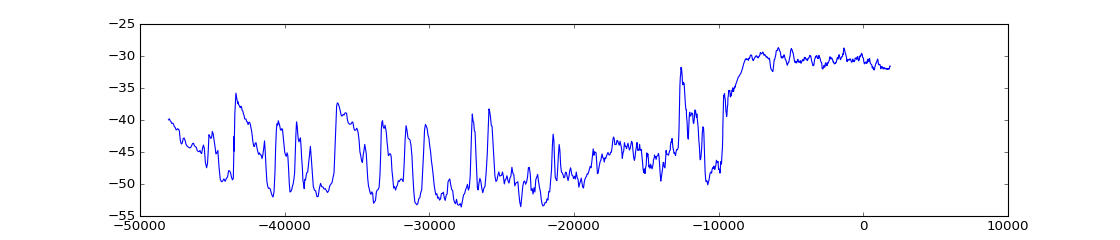

<IPython.core.display.Javascript object>


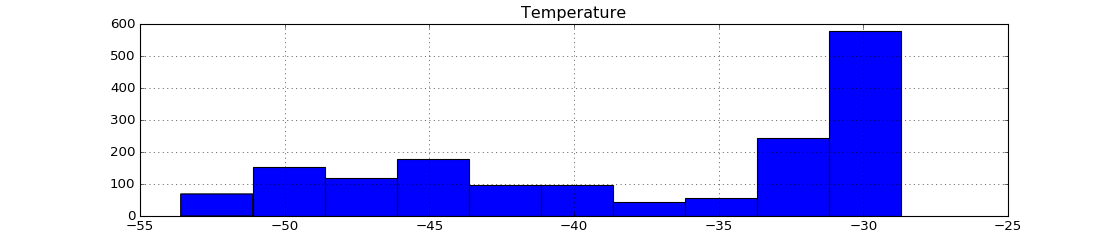

In [3]:
#Lets take a look at a standard histogram of the datapoints to see the distribution

plt.close()
width_height(14,3)
disappear = plt.plot(gisp2)
disappear = gisp2.hist()

### Something is very wrong here. The graph shows most datapoints in the -45C area but the histogram shows most in -30 zone...
### Lets graph the index to see if that shows anything

<IPython.core.display.Javascript object>


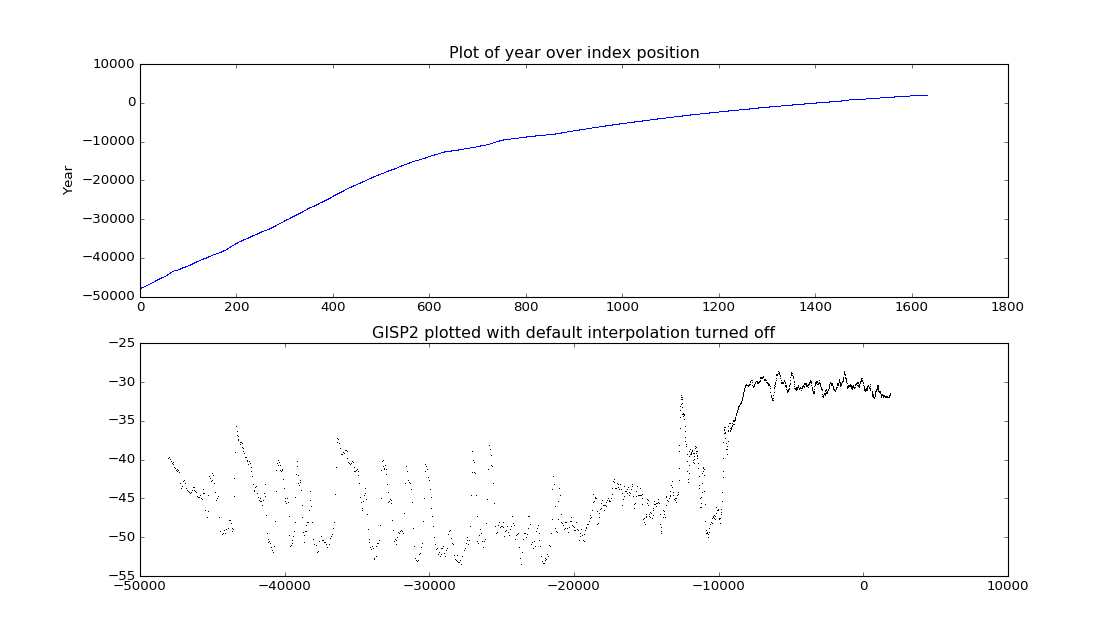

In [4]:
plt.close(1)
plt.close()
width_height(14,8)
f,ax = plt.subplots(2)
ax[0].plot(gisp2.index,',')
ax[0].set_title('Plot of year over index position')
ax[0].set_ylabel('Year')
ax[1].plot(gisp2,'k,')
ax[1].set_title('GISP2 plotted with default interpolation turned off')

## The frequency of sampling increases toward the present. We will have to do a linear interpolation using scipy to fix this.

### Since the sampling is buggered anyway, we may as well append the last 150 years from a nearby site first before we interpolate.



### The GRIP site should be suitable. It is 28kms from the GISP2 site and has a weatherstation with data going back to 1840.  Although the temperatures are slightly different at the two sites, the variations in temperature *should* be well enough matched to allow merging the two datasets. Unfortunately, all I have at the moment is a picture of the data that I will have to manually calculate the mean.

<IPython.core.display.Javascript object>


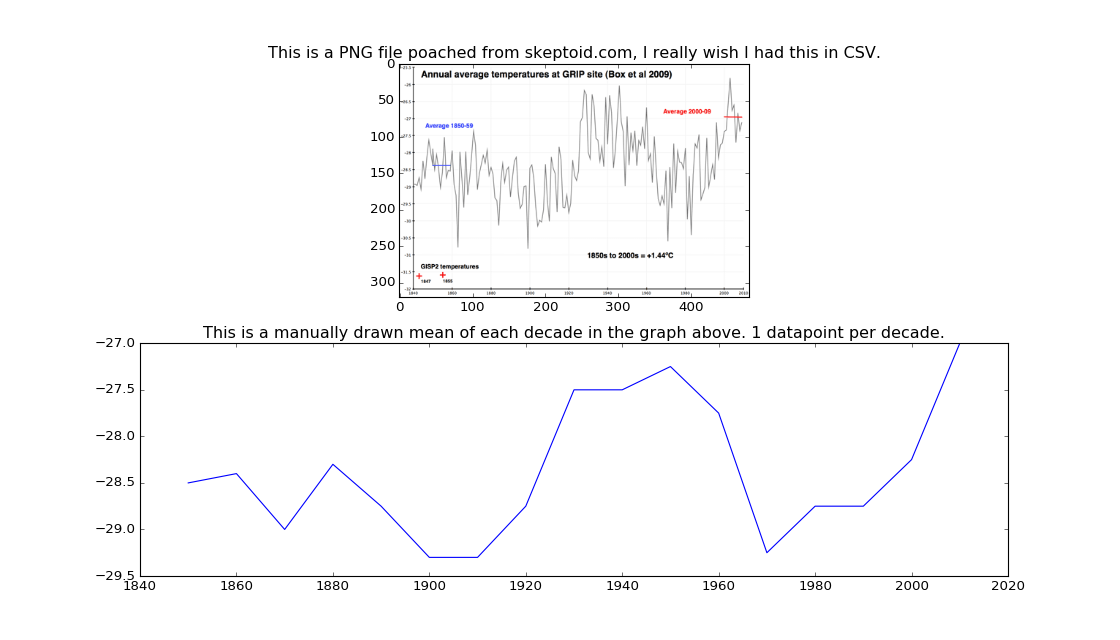

In [5]:
plt.close('all')
width_height(14,8)
grip = load_csv(r'grip_data.csv',parse_dates=False)
f,ax = plt.subplots(2)
ax[0].imshow(img.imread(r'GRIPtempBox480.png'))
ax[0].set_title('This is a PNG file poached from skeptoid.com, I really wish I had this in CSV.')

ax[1].plot(grip)
ax[1].set_title('This is a manually drawn mean of each decade in the graph above. 1 datapoint per decade.')

## Lets look at the data so that they merge well

In [6]:
grip.head(2)

,Temperature
1850.0,-28.5
1860.0,-28.4


In [7]:
gisp2.tail(2)

,Temperature
Year,
1842.8700,-31.6220
1854.8591,-31.5913


In [8]:
grip.Temperature = grip.Temperature + (gisp2.tail().Temperature.iat[-1] -grip.Temperature.iat[0])
gisp2 = gisp2.append(grip.ix[1:])
gisp2 = gisp2.sort_index(ascending=True)
gisp2[1840:1860]

,Temperature
Year,
1842.8700,-31.6220
1850.0000,-31.5913
1854.8591,-31.5913
1860.0000,-31.4913


## And now that the data is merged, lets take a closer look, zooming in on the splice.

<IPython.core.display.Javascript object>


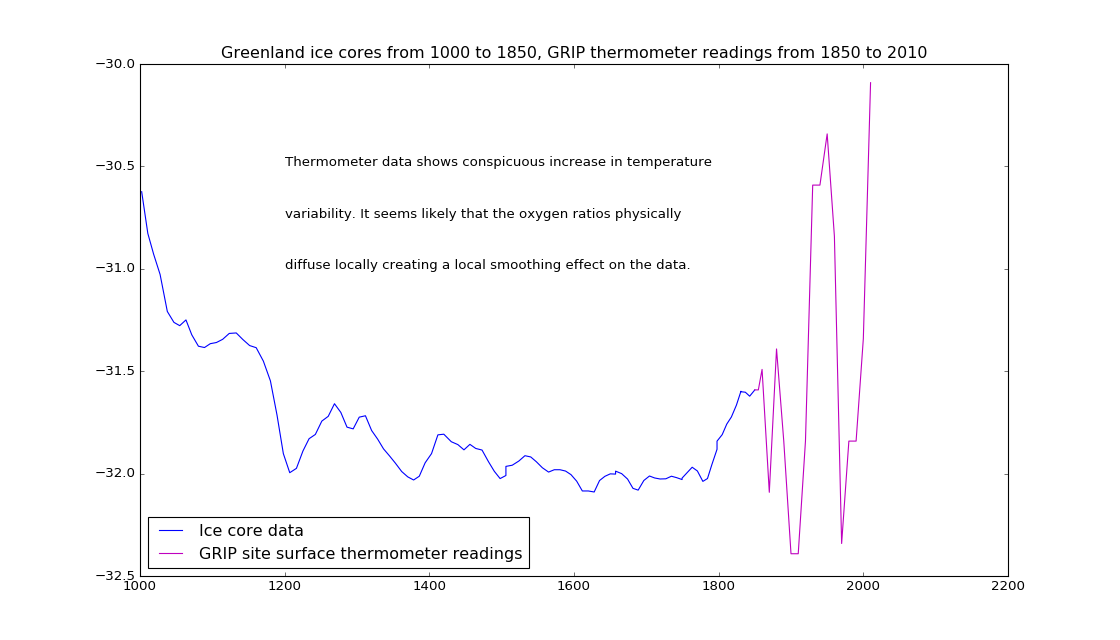

In [9]:
plt.close('all')
plt.plot(gisp2.Temperature.ix[1000:1850],'b-',label='Ice core data')
plt.plot(gisp2.Temperature.ix[1850:],'m-',label='GRIP site surface thermometer readings')

plt.title('Greenland ice cores from 1000 to 1850, GRIP thermometer readings from 1850 to 2010')
plt.annotate('Thermometer data shows conspicuous increase in temperature',xy=(1200,-30.5))
plt.annotate('variability. It seems likely that the oxygen ratios physically',xy=(1200,-30.75))
plt.annotate('diffuse locally creating a local smoothing effect on the data.', xy=(1200,-31.0))
plt.legend(loc='lower left')

<IPython.core.display.Javascript object>


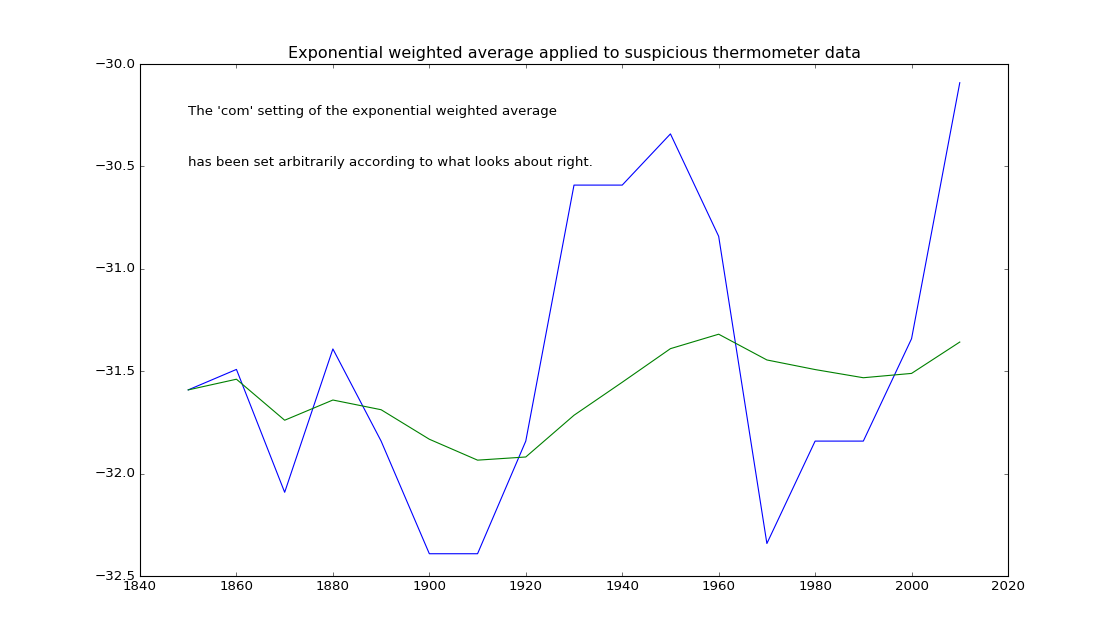

In [10]:
plt.close('all')
end = grip.Temperature.ix[1840:]
plt.plot(end)
plt.plot(end.ewm(com=11).mean())
plt.title('Exponential weighted average applied to suspicious thermometer data')
plt.annotate("The 'com' setting of the exponential weighted average",xy=(1850,-30.25))
plt.annotate("has been set arbitrarily according to what looks about right.",xy=(1850,-30.5))


<IPython.core.display.Javascript object>


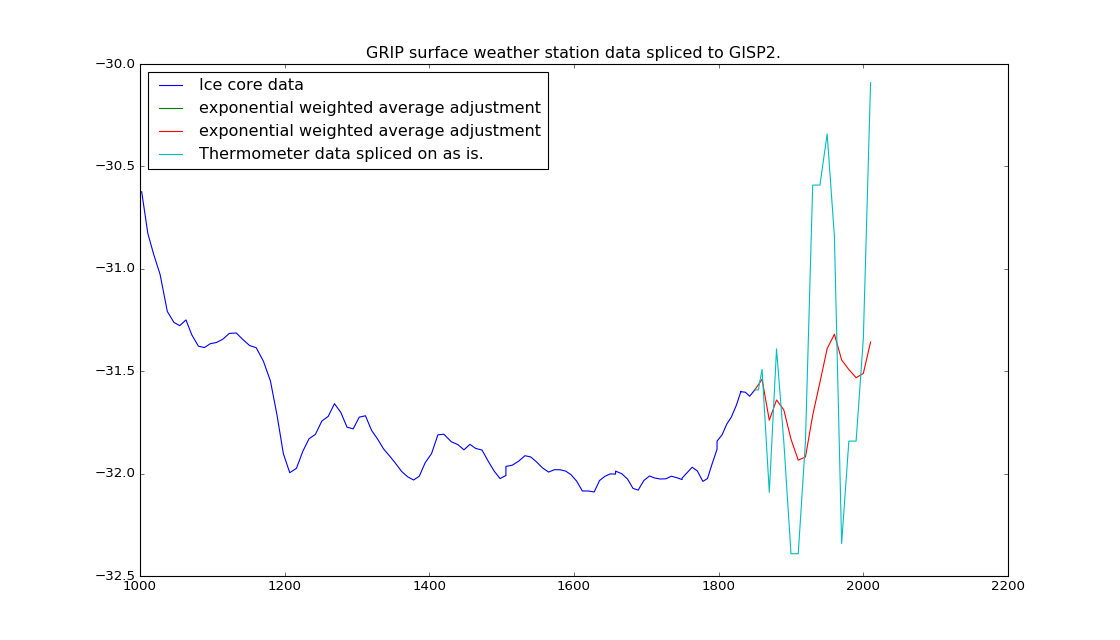

In [11]:
adj_gisp2 = pd.DataFrame(pd.concat((gisp2.Temperature.ix[:1840],grip.Temperature.ix[1840:].ewm(com=11).mean())), columns=['Year','Temperature'])
plt.close()
plt.plot(gisp2[1000:1850],label='Ice core data')
plt.plot(adj_gisp2[1850:],label='exponential weighted average adjustment')
plt.plot(gisp2[1850:],label='Thermometer data spliced on as is.')
plt.title('GRIP surface weather station data spliced to GISP2.')
plt.legend(loc='upper left')

## Okay, I'm happy that that adjustment, though arbitrary, is closer to the truth that what we had before.
## Using an arbitrary adjustment on the exponential moving average will probably be controversial without a good oxygen diffusion model to base it on, but I don't have any better ideas at the moment.

<IPython.core.display.Javascript object>


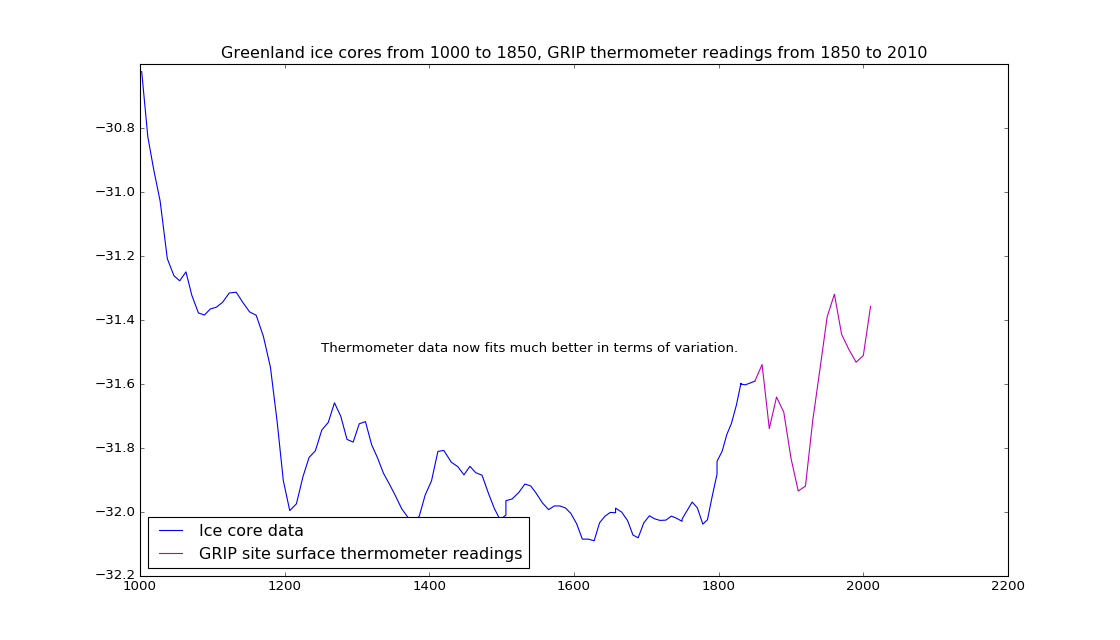

In [12]:
plt.close('all')
plt.plot(adj_gisp2.Temperature.ix[1000:1850],'b-',label='Ice core data')
plt.plot(adj_gisp2.Temperature.ix[1850:],'m-',label='GRIP site surface thermometer readings')

plt.title('Greenland ice cores from 1000 to 1850, GRIP thermometer readings from 1850 to 2010')
plt.annotate('Thermometer data now fits much better in terms of variation.',xy=(1250,-31.5))
plt.legend(loc='lower left')

In [13]:
# Preparing for linear interpolation because data has *highly* irregular sampling
xnew = np.arange(-47972,2010, 1) #hard coded start and end dates to interpolate one year data points between

# This next line looks strange because the function interp1d returns a function
#which immediately takes xnew as the argument
ynew = interpolate.interp1d(adj_gisp2.index.values,adj_gisp2.Temperature.values)(xnew) # use interpolation function

# Build a DataFrame with the interpolated data but with a standard counting integer index
adj_gisp2 = pd.DataFrame({'Year':xnew,'Temperature':ynew},index=xnew)

adj_gisp2.index = adj_gisp2.index.astype(int)

#Cleanup by showing only datapoints at least one year from previous one.
x = len(adj_gisp2)
adj_gisp2['Ydiff']= adj_gisp2.Year - adj_gisp2.Year.shift(1)
adj_gisp2 = adj_gisp2[adj_gisp2.Ydiff >0]
if len(adj_gisp2) == x:
    print('no need for clean-up step')

<IPython.core.display.Javascript object>


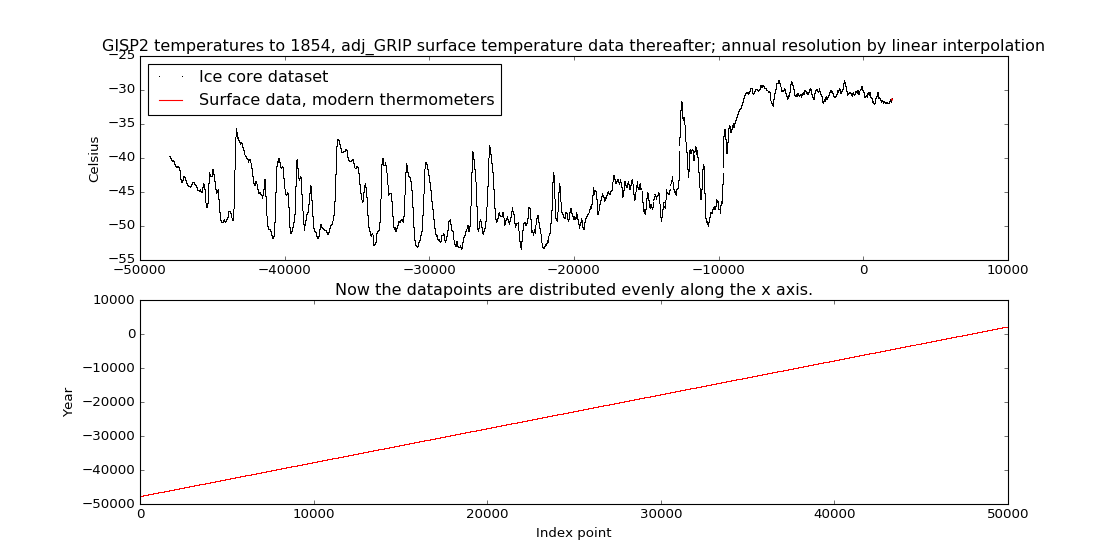

In [14]:
plt.close()
width_height(14,7)

f, ax = plt.subplots(2)

ax[0].plot(adj_gisp2.Temperature.ix[:1950],'k,', label='Ice core dataset')
ax[0].plot(adj_gisp2.Temperature.ix[1950:],'r-',linewidth=1, label='Surface data, modern thermometers')

ax[0].set_title('GISP2 temperatures to 1854, adj_GRIP surface temperature data thereafter; annual resolution by linear interpolation')
ax[0].legend(loc='upper left')
ax[0].set_ylabel('Celsius')
ax[1].plot(adj_gisp2.index,'r,')
ax[1].set_ylabel('Year')
ax[1].set_xlabel('Index point')
ax[1].set_title('Now the datapoints are distributed evenly along the x axis.')

In [15]:
# Create a new column named Tdiff from the differences between each temperature and the previous one.
# This creates a rolling one year differential. By changing the arg of shift() one can look at different sized differentials
adj_gisp2['diff_30yr']= adj_gisp2.Temperature - adj_gisp2.Temperature.shift(30)
adj_gisp2['diff_100yr']=adj_gisp2.Temperature - adj_gisp2.Temperature.shift(100)
adj_gisp2['adiff_100yr']=abs(adj_gisp2.Temperature - adj_gisp2.Temperature.shift(100))

adj_gisp2['diff_200yr']=adj_gisp2.Temperature - adj_gisp2.Temperature.shift(200)

<IPython.core.display.Javascript object>


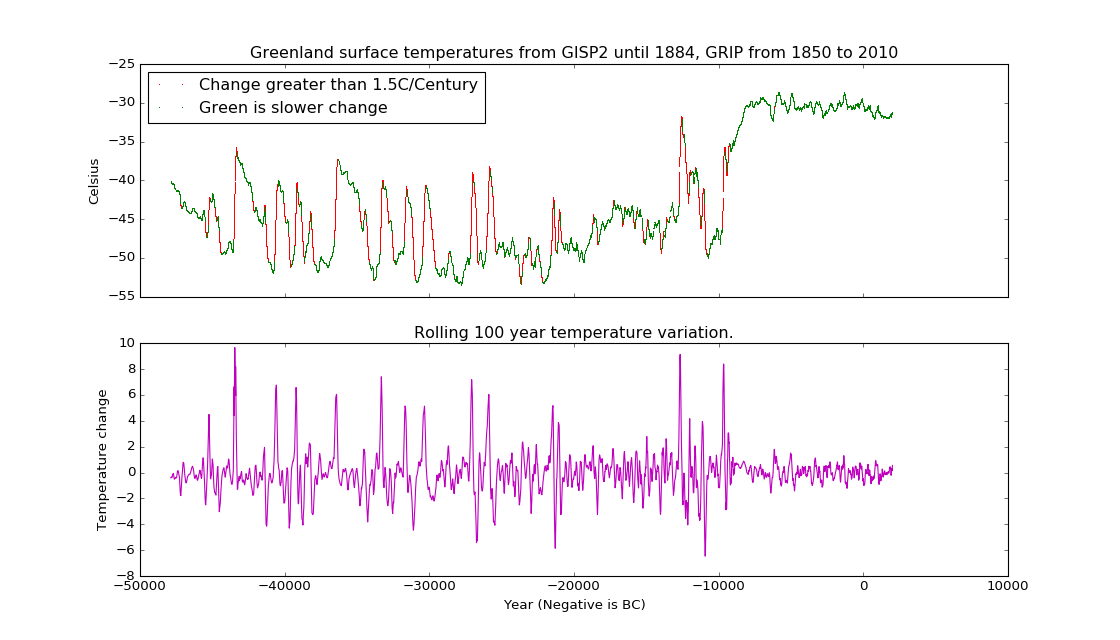

In [16]:
plt.close('all')

width_height(14,8)
f,ax = plt.subplots(2,sharex=True)
ax[0].plot(adj_gisp2[adj_gisp2.adiff_100yr>=1.5].Temperature,'r,',label='Change greater than 1.5C/Century')
ax[0].plot(adj_gisp2[adj_gisp2.adiff_100yr<1.5].Temperature,'g,',label='Green is slower change')
ax[1].plot(adj_gisp2.diff_100yr,'m-')
ax[0].legend(loc='upper left')


#Chart sizing and labelling
width_height(15,7)
ax[1].set_title('Rolling 100 year temperature variation.')
ax[0].set_title('Greenland surface temperatures from GISP2 until 1884, GRIP from 1850 to 2010')
ax[0].set_ylabel('Celsius')
ax[1].set_ylabel('Temperature change')
ax[1].set_xlabel("Year (Negative is BC)")

### Looks like a lot of history has been quite climatically unfavorable to human civilization... 
### Lets investigate these other compressions... what about trend analysis?

<IPython.core.display.Javascript object>


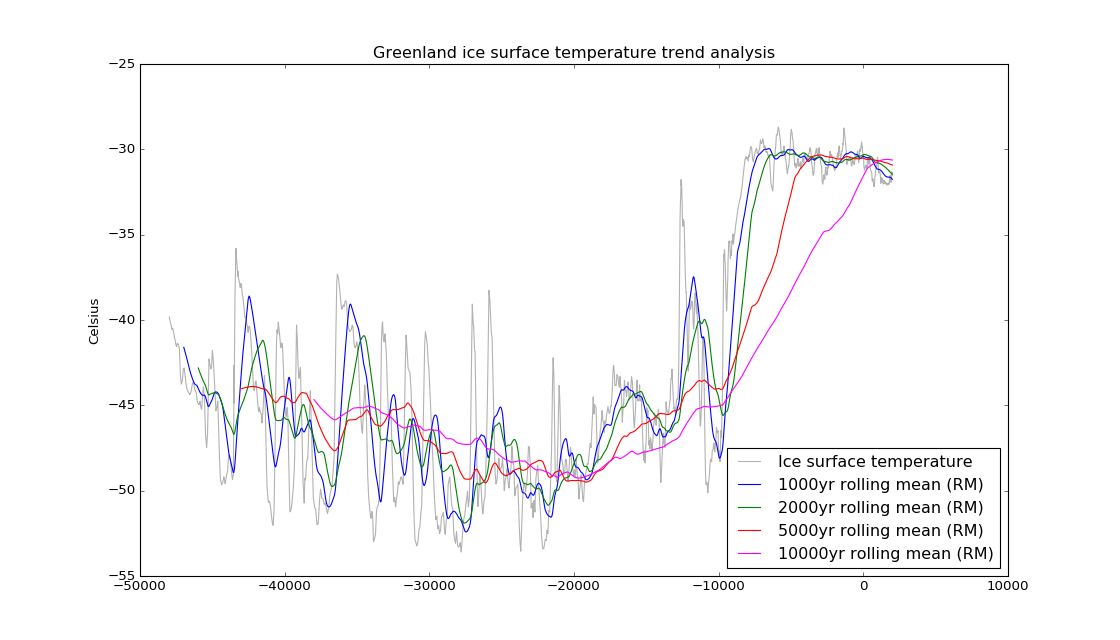

The 10000 year trend at the last datapoint is -0.0001 degrees celsius per year


In [17]:
plt.close('all')
width_height(14,8)
plt.plot(adj_gisp2.Temperature,'k-',alpha=.3, label='Ice surface temperature')
plt.plot(adj_gisp2.Year,adj_gisp2.Temperature.rolling(window=1000).mean(), label='1000yr rolling mean (RM)')
plt.plot(adj_gisp2.Year,adj_gisp2.Temperature.rolling(window=2000).mean(), label='2000yr rolling mean (RM)')
plt.plot(adj_gisp2.Year,adj_gisp2.Temperature.rolling(window=5000).mean(), label='5000yr rolling mean (RM)')
plt.plot(adj_gisp2.Year,adj_gisp2.Temperature.rolling(window=10000).mean(),label='10000yr rolling mean (RM)', color='magenta')
plt.title('Greenland ice surface temperature trend analysis')
plt.ylabel('Celsius')
plt.legend(loc='lower right')
first_derivative_10000y = adj_gisp2.Temperature.rolling(window=10000).mean()
second_derivative_10000y = first_derivative_10000y - first_derivative_10000y.shift(1)
print('The 10000 year trend at the last datapoint is {s} degrees celsius per year'.format(s=round(second_derivative_10000y.tail().values[-1],4)))

## All these trends from 1000 up to 10000 years are downward trends! 

Look out below, there is quite a drop possible.

In [18]:
def how_often_do_greenland_temperatures_change_by_more_than_x_degrees_celsius_in_y_years_function(df,degrees,how_long,debug=False):
    total_years = len(df)
    df1 = df.copy(deep=True)
    df1['differential'] = abs(df.Temperature - df.Temperature.shift(how_long))
    result = df1[df1.differential>degrees]
    print('Greenland temperatures changed by more than {d} degrees in {y} years {s} percent of the time.'.format(s=round(len(result)/total_years*100,2),d=degrees,y=how_long))
    if debug == True:
        return result

how_often_do_greenland_temperatures_change_by_more_than_x_degrees_celsius_in_y_years_function(gisp2,2.5,100)

Greenland temperatures changed by more than 2.5 degrees in 100 years 38.2 percent of the time.


In [27]:
adj_gisp2['diff_100yr'] = adj_gisp2.Temperature - adj_gisp2.Temperature.shift(100)
adj_gisp2.Temperature.rolling(100).mean()
adj_gisp2.tail()

,Temperature,Year,Ydiff,diff_30yr,diff_100yr,adiff_100yr,diff_200yr
2005,-31.434185,2005,1.0,0.034353,0.449071,0.449071,0.374589
2006,-31.418866,2006,1.0,0.054360,0.474605,0.474605,0.381758
2007,-31.403547,2007,1.0,0.074368,0.500138,0.500138,0.388927
2008,-31.388228,2008,1.0,0.094375,0.525672,0.525672,0.396095
2009,-31.372909,2009,1.0,0.114382,0.551205,0.551205,0.403264


In [32]:
len(adj_gisp2.diff_100yr.rolling(100).mean().values[:10000])

10000

<IPython.core.display.Javascript object>


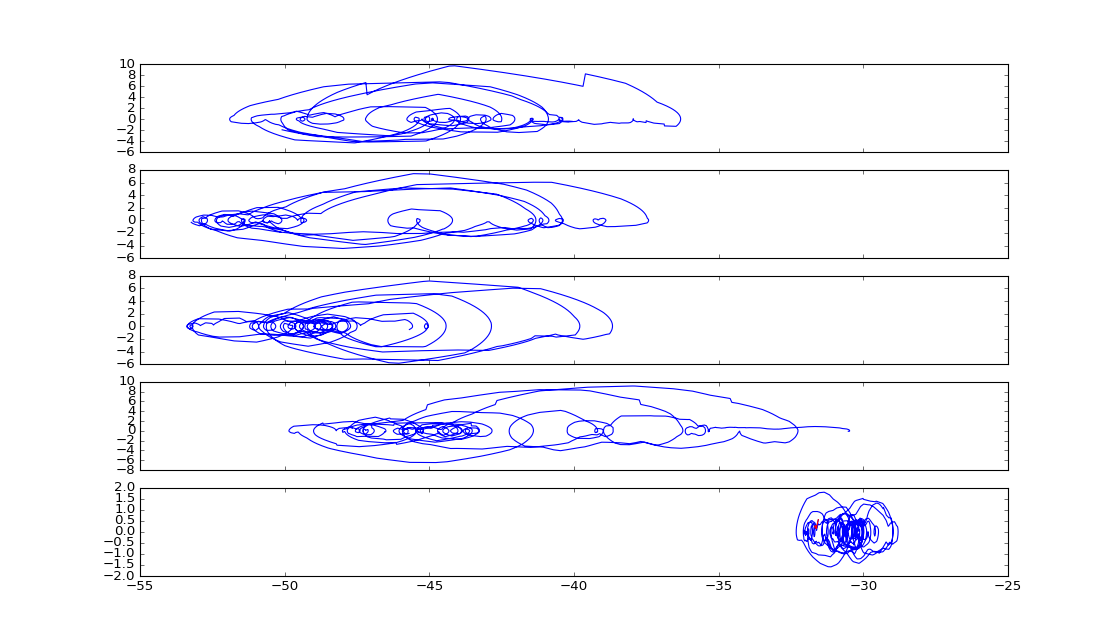

In [43]:
plt.close('all')
f,ax = plt.subplots(5, sharex=True)
ax[0].plot(adj_gisp2.Temperature.rolling(100).mean().values[:10000],adj_gisp2.diff_100yr.values[:10000],label='-50000 to -40000')
#ax[0].set_legend(loc='upper left')
ax[1].plot(adj_gisp2.Temperature.rolling(100).mean().values[10001:20000],adj_gisp2.diff_100yr.values[10001:20000],label='-40000 to -30000')
#ax[1].set_legend(loc='upper left')
ax[2].plot(adj_gisp2.Temperature.rolling(100).mean().values[20001:30000],adj_gisp2.diff_100yr.values[20001:30000],label='-30000 to -20000')
#ax[2].set_legend(loc='upper left')
ax[3].plot(adj_gisp2.Temperature.rolling(100).mean().values[30001:40000],adj_gisp2.diff_100yr.values[30001:40000],label='-30000 to -20000')
#ax[3].set_legend(loc='upper left')

ax[4].plot(adj_gisp2.Temperature.rolling(100).mean().values[40001:],adj_gisp2.diff_100yr.values[40001:],label='-10000 to present')
ax[4].plot(adj_gisp2.Temperature.rolling(100).mean().values[-50:],adj_gisp2.diff_100yr.values[-50:],'r-',label='-10000 to present')

#ax[4].set_legend(loc='upper left')

<IPython.core.display.Javascript object>


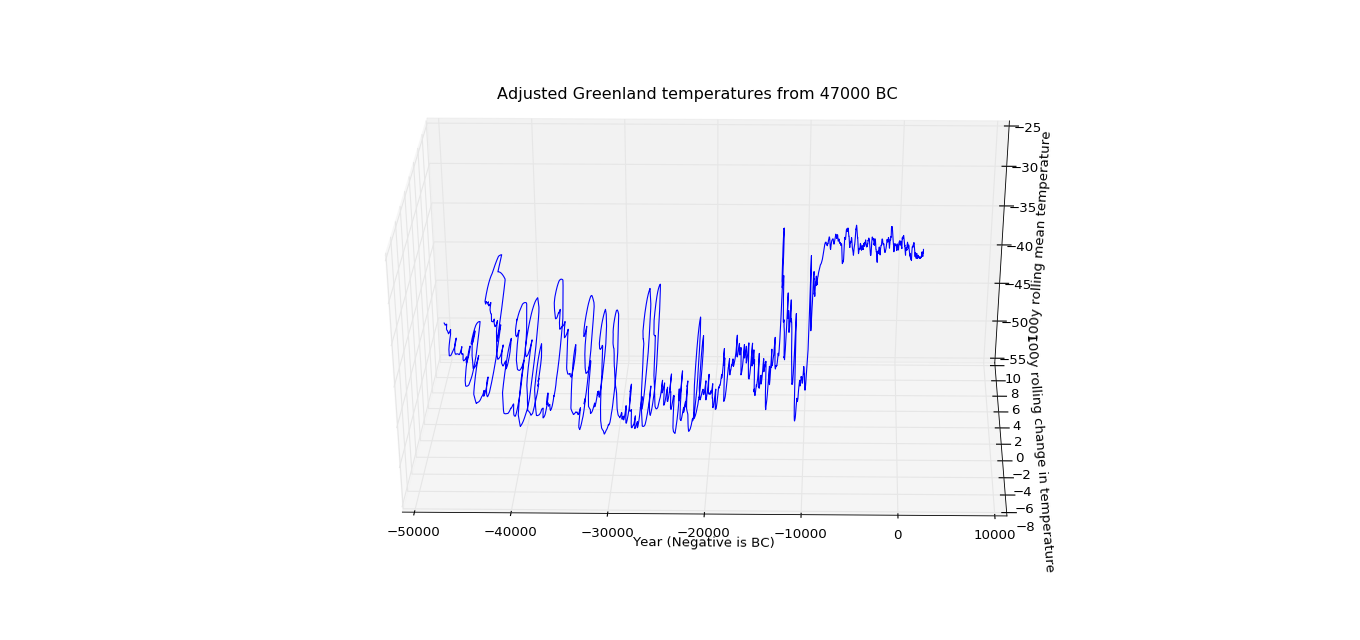

In [55]:
from mpl_toolkits.mplot3d import Axes3D
width_height(17,8)
plt.close('all')
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(adj_gisp2.index,adj_gisp2.diff_100yr.values,adj_gisp2.Temperature.rolling(100).mean().values)
plt.title('Adjusted Greenland temperatures from 47000 BC')
ax.set_xlabel('Year (Negative is BC)')
ax.set_ylabel('100y rolling change in temperature')
ax.set_zlabel('100y rolling mean temperature')